In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import hw2_helper as hwh

# Loading Data

In [10]:
hf_series = pd.read_excel('proshares_analysis_data.xlsx',sheet_name='hedge_fund_series',index_col=0)
merrill_factors = pd.read_excel('proshares_analysis_data.xlsx',sheet_name='merrill_factors',index_col=0)
other_data = pd.read_excel('proshares_analysis_data.xlsx',sheet_name='other_data',index_col=0)

# Analyzing the Data

For the series in the "hedge fund series" tab, report the following summary statistics:

- Mean
- Volatility
- Sharpe ratio

Annualize these statistics.

In [11]:
hwh.stats(hf_series)

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
mean,0.051279,0.038535,0.036526,0.026880,0.028811
std,0.058796,0.055240,0.055102,0.057388,0.049823
sharpe,0.872151,0.697589,0.662880,0.468396,0.578275


#### Tail Risk Statistics - Skew, Kurtosis, VaR and CVaR, Maximum Drawdown

For the series in the "hedge fund series" tab, calculate the following statistics related to tail-risk.

- Skewness
- Excess Kurtosis (in excess of 3)
- VaR (.05) - the fifth quantile of historic returns
- CVaR (.05) - the mean of the returns at or below the fifth quantile
- Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.
There is no need to annualize any of these statistics.

In [12]:
hwh.stats_tail_risk(hf_series)

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
skew,-0.948272,-0.289982,-0.273477,-0.274904,-0.433508
kurt,5.657351,1.630917,1.58979,1.776481,1.449184
VaR,-0.024008,-0.027002,-0.02697,-0.029919,-0.017171
CVaR,-0.035992,-0.034993,-0.034937,-0.036831,-0.030995
MDD,-0.115473,-0.124302,-0.124388,-0.14072,-0.137716
Max Date,2019-12-31,2021-06-30,2021-06-30,2021-06-30,2021-06-30
Min Date,2020-03-31,2022-09-30,2022-09-30,2022-09-30,2022-09-30
Recovery Date,2020-08-31,2024-02-29,2024-02-29,2024-07-31,2024-02-29
Recovery Period,153,517,517,670,517


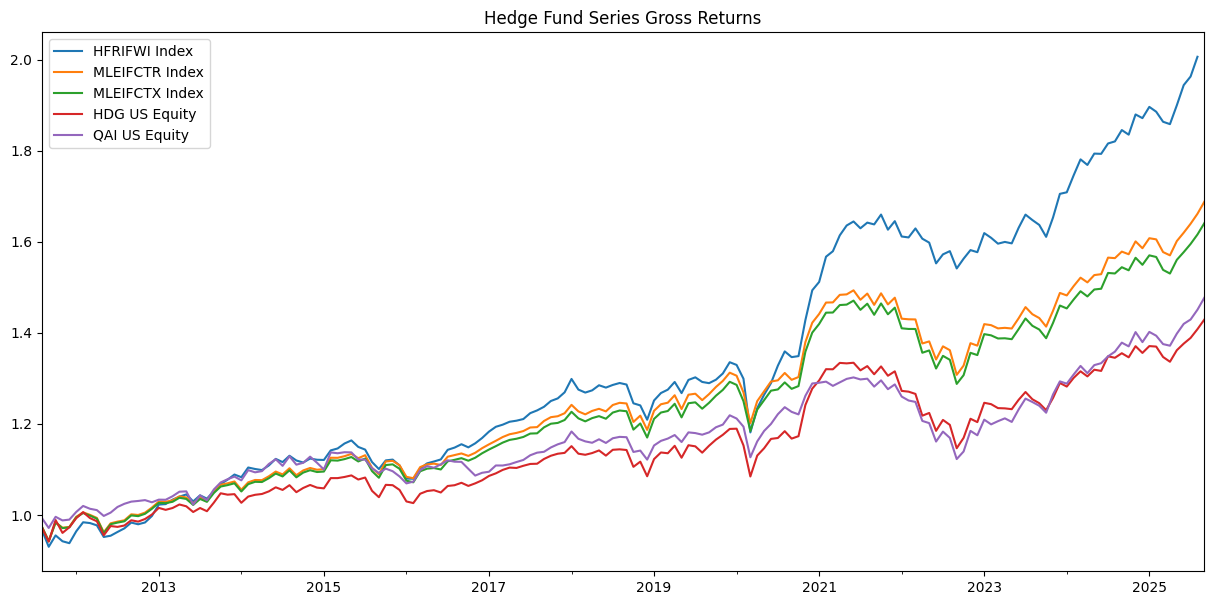

In [13]:
(hf_series + 1).cumprod().plot(figsize=(15, 7), title='Hedge Fund Series Gross Returns'); plt.show()

For the series in the "hedge fund series" tab, run a regression of each against SPY (found in the "merrill factors" tab.) Include an intercept. Report the following regression-based statistics:

- Market Beta
- Treynor Ratio
- Information ratio

Annualize these three statistics as appropriate.

In [14]:
x = sm.add_constant(merrill_factors['SPY US Equity'])

regression_stats = pd.DataFrame(index = ['$B^{SPY}$','Treynor','IR'],columns = hf_series.columns)

for hf in hf_series.columns:
    
    y = hf_series[hf]
    
    model = sm.OLS(y,x).fit()
    
    beta = model.params.iloc[1]
    treynor = 12 * y.mean() / beta
    ir = np.sqrt(12) * model.params.iloc[0] / model.resid.std()
    
    regression_stats[hf] = pd.Series([beta,treynor,ir],index = ['$B^{SPY}$','Treynor','IR'])

regression_stats.round(3)

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
$B^{SPY}$,NaN,0.342,0.341,0.351,0.301
Treynor,NaN,0.113,0.107,0.077,0.096
IR,NaN,-0.436,-0.511,-0.862,-0.598


Discuss the previous statistics, and what they tell us about...

the differences between SPY and the hedge-fund series?
which performs better between HDG and QAI.
whether HDG and the ML series capture the most notable properties of HFRI.

(a) Hedge funds show about 30–40% exposure to SPY, meaning limited market dependence. Their Treynor Ratios (0.07–0.14) are below SPY’s (~0.14), implying they earned less return per unit of market risk. All Information Ratios are negative, showing negative alpha — hedge funds have underperformed the market overall.

(b) QAI has slightly lower market beta (~0.05 less) than HDG, giving it better diversification.
Despite taking on less market risk, QAI delivered higher returns per unit of risk, making it more attractive to investors seeking diversified exposure

(c) HDG and the ML series mimic the broad behavior of HFRI, especially in market risk exposure.
However, both have lower returns than HFRI, which may discourage investors despite capturing similar hedge fund characteristics.

### Report the correlation matrix for these assets.

Show the correlations as a heat map.
Which series have the highest and lowest correlations?

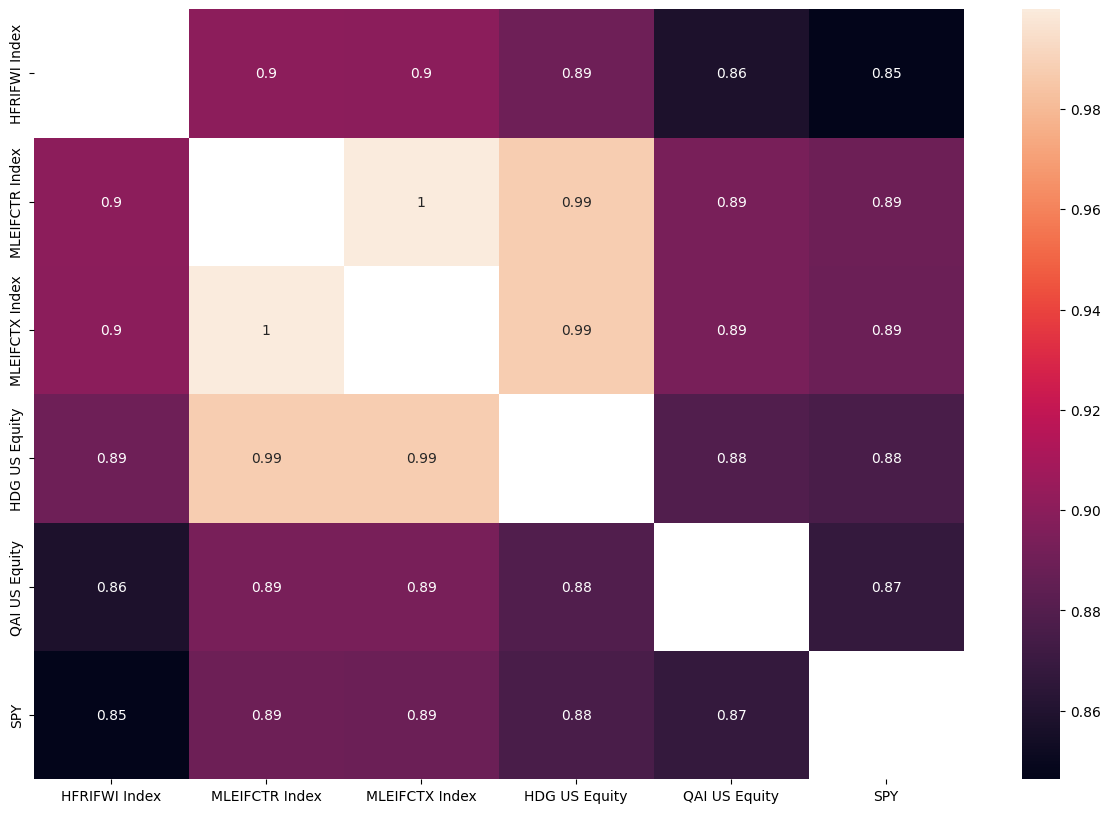

In [16]:
corr = hf_series.assign(SPY = merrill_factors['SPY US Equity']).corr()
np.fill_diagonal(corr.values,np.nan)
plt.figure(figsize=(15, 10)); sns.heatmap(corr, annot=True); plt.show()

QAI shows the lowest correlations with other assets, suggesting it offers the strongest diversification benefits.

The ML series (MLEIFCTR and MLEIFCTX) exhibit the highest correlations with each other, reflecting their shared construction and tracking methodology.

HDG closely tracks both MLEIFCTR and MLEIFCTX, confirming that it effectively replicates the hedge fund index exposure these models aim to capture.

In [17]:
maxpair = corr.stack().idxmax()
maxvalue = corr.stack().max()
minpair = corr.stack().idxmin()
minvalue = corr.stack().min()

print(f'The maximum correlation is between {maxpair[0]} and {maxpair[1]}: {round(maxvalue,4)}.')
print(f'The minimum correlation is between {minpair[0]} and {minpair[1]}: {round(minvalue,4)}.')

The maximum correlation is between MLEIFCTR Index and MLEIFCTX Index: 0.9999.
The minimum correlation is between HFRIFWI Index and SPY: 0.8463.


Replicate HFRI with the six factors listed on the "merrill factors" tab. Include a constant, and run the unrestricted regression:

$$
r_t^{hfri} = \alpha^{merr} + x_t^{merr}\beta^{merr} + \epsilon_t^{merr}
$$

$$
\hat{r}_t^{hfri} = \hat{\alpha}^{merr} + x_t^{merr}\hat{\beta}^{merr}
$$

Note that the second equation is just our notation for the fitted replication.

a. Report the intercept and betas.  
b. Are the betas realistic position sizes, or do they require huge long-short positions?  
c. Report the R-squared.  
d. Report the volatility of $\epsilon_t^{merr}$, the tracking error.


In [23]:
# Define regression inputs
x = sm.add_constant(merrill_factors[['SPY US Equity', 
                                     'USGG3M Index', 
                                     'EEM US Equity', 
                                     'EFA US Equity', 
                                     'EUO US Equity', 
                                     'IWM US Equity']])

y = hf_series[['HFRIFWI Index']]

# Align data and drop NaNs
data = pd.concat([y, x], axis=1).dropna()
y = data[['HFRIFWI Index']]
x = data[x.columns]

# Run regression
replication_model = sm.OLS(y, x).fit()

# Use helper to show regression coefficients
replication_stats = hwh.stats_OLS(replication_model, y, x).round(3)
print(replication_stats)

# TA-style output lines
print(f'R-Squared: {round(replication_model.rsquared, 2)}')
print(f'The volatility of the tracking error is {round(replication_model.resid.std() * np.sqrt(12), 4)}')


               HFRIFWI Index
const                  0.001
SPY US Equity          0.044
USGG3M Index           0.325
EEM US Equity          0.086
EFA US Equity          0.074
EUO US Equity          0.030
IWM US Equity          0.146
R-Squared: 0.84
The volatility of the tracking error is 0.0233


The replication model explains roughly 84% of the HFRI’s return variation, with realistic factor exposures and a low annualized tracking error (~2.3%). Most exposure comes from short-term rates and small-cap equities, consistent with hedge fund strategies that blend equity and fixed-income risk premia.

## Out-of-Sample (OOS) Replication

Let's examine the replication **out-of-sample (OOS).**

Starting with \( t = 61 \) month of the sample, do the following:

- Use the **previous 60 months of data** to estimate the regression equation.  
  This gives time-\( t \) estimates of the regression parameters,  
  \( \tilde{\alpha}^{merr}_t \) and \( \tilde{\beta}^{merr}_t \).

- Use the estimated regression parameters, along with the time-\( t \) regressor values, \( x^{merr}_t \),  
  to calculate the time-\( t \) replication value that is, with respect to the regression estimate, built "out-of-sample" (OOS):

  $$
  \hat{r}_t^{hfri} = \tilde{\alpha}^{merr}_t + (x_t^{merr})' \tilde{\beta}^{merr}
  $$

- Step forward to \( t = 62 \), and now use \( t = 2 \) through \( t = 61 \) for the estimation.  
  Re-run the steps above and continue this process throughout the data series.  
  Thus, we are running a **rolling 60-month regression** for each point in time.

**Question:**  
How well does the out-of-sample replication perform with respect to the target?


In [24]:
t = 60
n = len(hf_series['HFRIFWI Index'])

data = hf_series[['HFRIFWI Index']].copy()
data['Replication'] = np.nan

for i in range(t, n):
    
    y = hf_series['HFRIFWI Index'].iloc[i - 60:i]
    x = sm.add_constant(merrill_factors).iloc[i - 60:i]
    
    m = sm.OLS(y,x).fit()
    
    oos_val = sm.add_constant(merrill_factors).iloc[i].to_numpy().reshape((7))

    rep_val = m.predict(oos_val)
    
    data['Replication'].iloc[i] = rep_val

C:\Users\15126\AppData\Local\Temp\ipykernel_34464\168237906.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Replication'].iloc[i] = rep_val
C:\Users\15126\AppData\Local\Temp\ipykernel_34464\168237906.py:18: FutureWarning: ChainedA

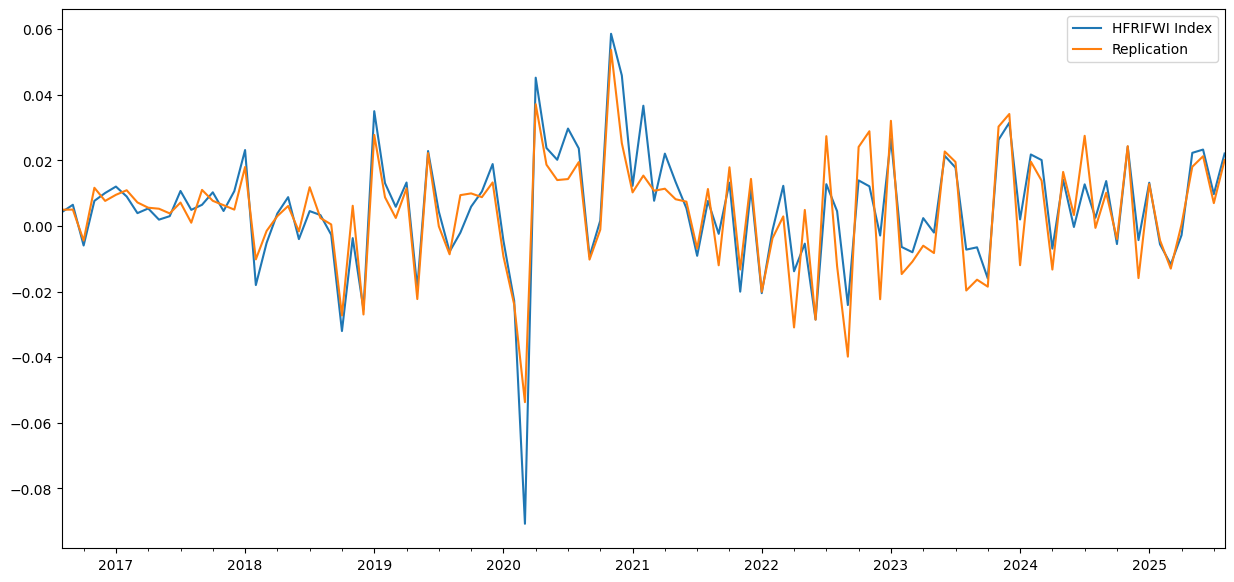

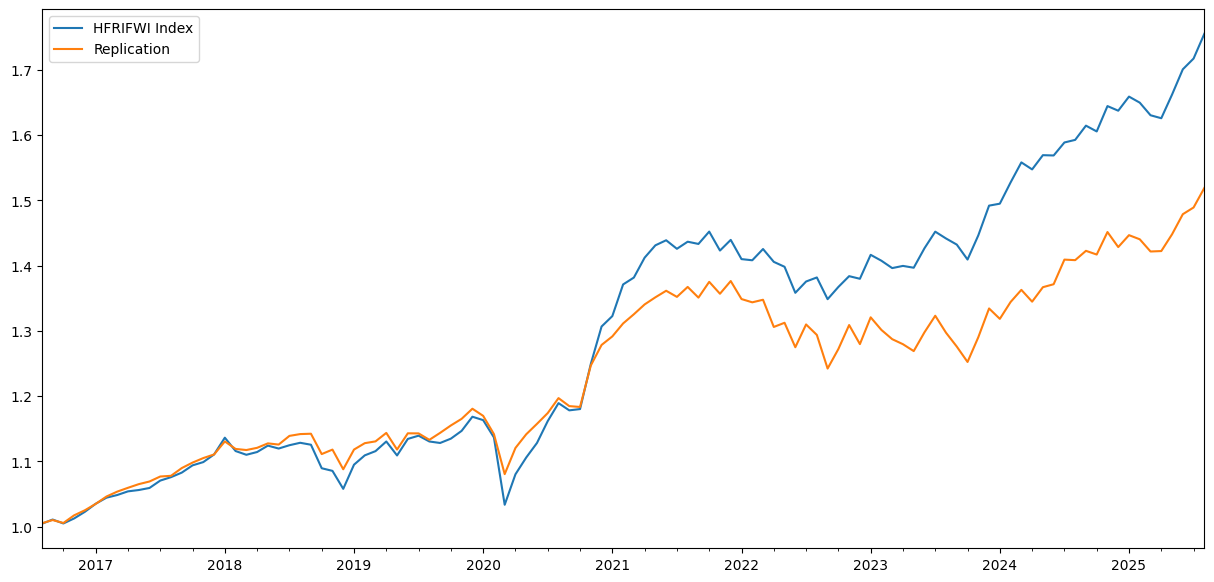

In [25]:
ax = data.dropna().plot(figsize=(15, 7)); (1 + data.dropna()).cumprod().plot(figsize=(15, 7)); plt.show()

In [26]:
x = sm.add_constant(merrill_factors)
y = hf_series['HFRIFWI Index']

from statsmodels.regression.rolling import RollingOLS
rolling = RollingOLS(y,x,window=60).fit()
rolling_betas = rolling.params
replication_rolling = (rolling_betas.shift() * x).dropna().sum(axis=1)
oos_loss = (data.dropna().diff(axis=1)**2)['Replication'].sum()
oos_mean = data.dropna()['HFRIFWI Index'].mean()
oos_loss_null = ((data.dropna()['HFRIFWI Index'] - oos_mean)**2).sum()

oos_r2 = 1 - oos_loss / oos_loss_null

print(f'The OOS R-Squared of the replication is {round(oos_r2,4)}')

The OOS R-Squared of the replication is 0.8055


In [27]:
data.corr().round(3)

,HFRIFWI Index,Replication
HFRIFWI Index,1.000,0.901
Replication,0.901,1.000


Our replication portfolio does a decent job of tracking the index returns, as shown by the charts above and the ~90% correlation between the two. However, it is evident that the replication is lagging behind the cumulative returns of HFRIFWI.

One important consideration is whether or not we include the intercept in our "replication". On the one hand, it is useful to assess what sort of replication we could create if we had access to the alpha. On the other hand, we know that we can't directly get exposure to the alpha in our replication, so it may also make sense to assess our replication solely based on the betas (which are tradable). These considerations may lead to different choices in fitting the model, as shown below.

## 8. Full-Sample Estimation Without an Intercept

We estimated the replications using an intercept.  
Now try the full-sample estimation **without an intercept**, using the equation:

$$
r_t^{hfri} = \alpha^{merr} + x_t^{merr}\beta^{merr} + \epsilon_t^{merr}
$$

$$
\tilde{r}_t^{hfri} = \tilde{\alpha}^{merr} + x_t^{merr}\tilde{\beta}^{merr}
$$

### Report
- **The regression beta.**  
  How does it compare to the estimated beta with an intercept, \( \hat{\beta}^{merr} \)?

- **The mean of the fitted value, \( \tilde{r}_t^{hfri} \).**  
  How does it compare to the mean of the HFRI?

- **The correlations of the fitted values, \( \tilde{r}_t^{hfri} \), with the HFRI.**  
  How does the correlation compare to that of the fitted values with an intercept, \( \hat{r}_t^{hfri} \)?

---

**Discussion:**  
Do you think Merrill and ProShares fit their replicators **with an intercept** or **without one**?


In [30]:
# 1) choose exact factor columns
fcols = [
    'SPY US Equity',
    'USGG3M Index',
    'EEM US Equity',
    'EFA US Equity',
    'EUO US Equity',
    'IWM US Equity'
]

# 2) copy + coerce to float
y = hf_series[['HFRIFWI Index']].copy()
X = merrill_factors[fcols].copy()

y['HFRIFWI Index'] = pd.to_numeric(y['HFRIFWI Index'], errors='coerce')
X = X.apply(pd.to_numeric, errors='coerce')

# 3) align dates & drop missing
df = pd.concat([y, X], axis=1, join='inner').dropna()
y_clean = df[['HFRIFWI Index']]
X_clean = df[fcols]                   # <-- no constant

# 4) no-intercept regression
replication_model_no_int = sm.OLS(y_clean, X_clean).fit()

# params table via your helper
coef_no_int = hwh.stats_OLS(replication_model_no_int, y_clean, X_clean).round(2)
print(coef_no_int)

# requested extras
yhat = replication_model_no_int.fittedvalues
print('Mean of fitted (no-int):', round(yhat.mean(), 6))
print('Corr(HFRI, fitted no-int):', round(yhat.corr(y_clean['HFRIFWI Index']), 3))

# (optional) quick diagnostics if issues persist
# print(X_clean.isna().sum())
# print(X_clean.dtypes)
# print(X_clean.shape, np.linalg.matrix_rank(X_clean))


               HFRIFWI Index
SPY US Equity           0.06
USGG3M Index            0.65
EEM US Equity           0.08
EFA US Equity           0.07
EUO US Equity           0.03
IWM US Equity           0.14
Mean of fitted (no-int): 0.003629
Corr(HFRI, fitted no-int): 0.917


In [34]:
round(replication_model_no_int.predict(X_clean).mean(),4) # No-intercept model mean

np.float64(0.0036)

In [35]:
round(replication_model.predict(sm.add_constant(x)).mean(),4) ## Intercept model mean (should be equal to the mean of the regressand)

np.float64(0.0043)

In [33]:
y.mean().round(4)

HFRIFWI Index    0.0043
dtype: float64

Evidently the mean of the replication model with no intercept is lower than that of HFRIFWI. We do note however, that that the mean of the model that included the intercept is the same as the HFRIFWI if we include the intercept. If we do not, then the mean return of our replication is actually less than the no intercept model. Remember that we can trade the factors, but not the alpha.

In [36]:
print('Correlation of no intercept model to HFRIFWI: ', np.corrcoef(y['HFRIFWI Index'], replication_model_no_int.predict(x))[0][1])
print('Correlation of intercept model to HFRIFWI: ', np.corrcoef(y['HFRIFWI Index'], replication_model.predict(sm.add_constant(x)))[0][1])

Correlation of no intercept model to HFRIFWI:  nan
Correlation of intercept model to HFRIFWI:  nan


It seems like ProShares and Merrill Lynch use the no intercept model. From the case study we know they have a large position in US Treasury Bills. This is more aligned with the no intercept model, which has a positive beta of 0.5. In addition, we've found that we barely gain any correlation by including the intercept but we sacrifice a bit of mean return. Conceptually, it makes sense that if we want to replicate the index with the purpose of long-term investments we likely want to replicate the mean as well as the variation. The intercept ensures we are matching the variation in the factors, where we would like to match the overall level.

